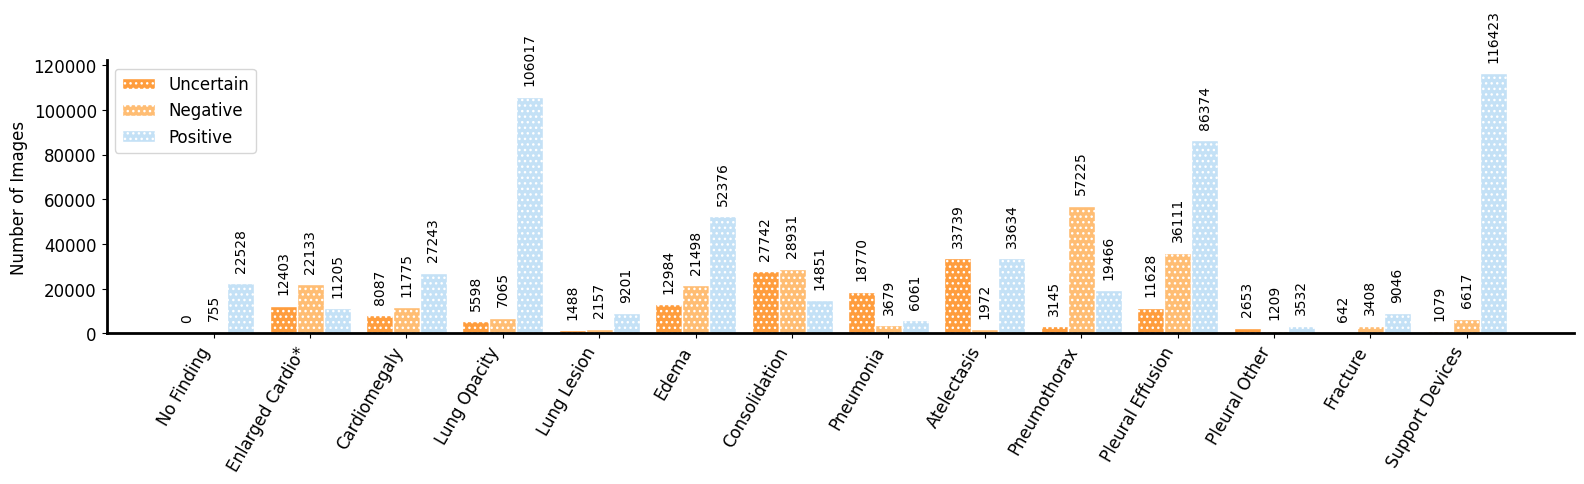

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
def data_show1():

    # 创建数据字典
    data_dict = {
            "No Finding":[0,755,22528],
            "Enlarged Cardio*":[12403.0,22133,11205],
            "Cardiomegaly":[8087.0,11775,27243],
            "Lung Opacity":[5598.0,7065,106017],
            "Lung Lesion":[1488,2157,9201],
            "Edema":[12984.0,21498,52376],
            "Consolidation":[27742,28931,14851],
            "Pneumonia":[18770.0,3679,6061],
            "Atelectasis":[33739.0,1972,33634],
            "Pneumothorax":[3145.0,57225,19466],
            "Pleural Effusion":[11628.0,36111,86374],
            "Pleural Other":[2653.0,1209,3532],
            "Fracture":[642.0,3408,9046],
            "Support Devices":[1079.0,6617,116423]
            
    }
    
    # 将字典转换为 DataFrame，并转置
    df = pd.DataFrame(data_dict).T
    df.columns = ['uncertain', 'negative', 'positive']

    # 创建柱状图
    plt.figure(figsize=(16, 5))
    x = np.arange(len(df.index))  # 获取分类的索引位置
    width = 0.28  # 每个柱子的宽度

    # 去掉上边框和右边框
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)

    # 绘制三组柱子
    bars1 = plt.bar(x - width, df['uncertain'], width, label='Uncertain', edgecolor="white", color='#FF9D3D', linewidth=1, hatch='...')
    bars2 = plt.bar(x, df['negative'], width, label='Negative', edgecolor="white", color='#FFBD73', lw=1, hatch='...')
    bars3 = plt.bar(x + width, df['positive'], width, label='Positive', edgecolor="white", color='#C4E1F6', lw=1, hatch='...')

    # 添加数据标签
    for bar in bars1 + bars2 + bars3:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5000,  # 偏移量可以根据需要调整
                f'{int(bar.get_height())}', ha='center', va="bottom", color='black', rotation=90, fontsize=10)

    # 设置y轴标签
    plt.ylabel('Number of Images', fontsize=12)

    # 设置x轴刻度和网格
    plt.xticks(x, df.index, rotation=60, ha='right')  # 设置x轴的标签

    # 添加图例
    plt.legend()

    # 调整布局和保存图像
    plt.tight_layout()
    plt.savefig('chest_data.png', dpi=330, transparent=True)  # 保存图像
    plt.show()  # 显示图像
data_show1()

In [9]:
label = "all"
folder_path = "/export/home/wuyueting/Chest_data/chexpert/"
test_csv =  "/export/home/wuyueting/Chest_data/chexpert/test_labels.csv"

# folder_path = "/export/home/wuyueting/Classification/Singlelabel/Densenet-case/chexpert/"
# test_csv = "/export/home/wuyueting/Classification/Singlelabel/Densenet-case/chexpert/CheXpert-v1.0-small/valid.csv"
model_name = "chest_resnet152"
target_layer="model.layer4[-1]"
target_save_name = model_name+target_layer
attr_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

# preprocess = transforms.Compose([
#     transforms.Resize(320),
#     transforms.CenterCrop(320),
#     lambda x: torch.from_numpy(np.array(x, copy=True)).float().div(255).unsqueeze(0),   # tensor in [0,1]
#     transforms.Normalize(mean=[0.5330], std=[0.0349]),                                           # whiten with dataset mean and std
#     lambda x: x.expand(3,-1,-1)]) 

t-test statistic: -18.696651393485062
p-value=5.054498221179635e-63: < 0.01


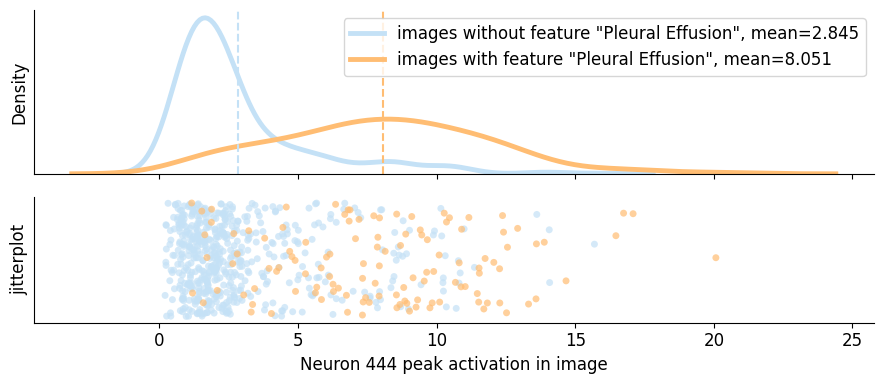

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import os
from utils import models, nethook, activ
import pandas as pd
from torchvision import transforms
import numpy as np
from scipy import stats

# 定义生成路径的函数
def reshape_transform(tensor, height=14, width=14):
    # 去掉类别标记
    result = tensor[:, 1:, :].reshape(tensor.size(0),
    height, width, tensor.size(2))

    # 将通道维度放到第一个位置
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def plot_jitter(neuron=444,attr_name="Pleural Effusion"):

    label_data = pd.read_csv(test_csv)
    image_files  = label_data.iloc[:, 0].tolist()
    # image_files = [os.path.join(folder_path, x) for x in image_files]
    
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()
    
    # ori_gradients = data[:, neuron, 0]
    ori_activations = data[:, neuron, 1]
    
    # for col in label_data.columns[1:]:
    # print(col)
    col = attr_name
    class_0_images= label_data[label_data[col]==0]['Path'].tolist()
    class_1_images= label_data[label_data[col]==1]['Path'].tolist()

    # print(class_0_images)


    class_0_indices = [idx for idx, img in enumerate(image_files) if img in class_0_images]
    class_1_indices = [idx for idx, img in enumerate(image_files) if img in class_1_images]



    activation_0 = ori_activations[class_0_indices].tolist()  
    activation_1 = ori_activations[class_1_indices].tolist()

    mean_activation_0 = np.mean(activation_0)
    mean_activation_1 = np.mean(activation_1)

            # 进行独立样本 t 检验
    # t_stat, p_value = stats.ttest_ind(activation_0, activation_1)

    # 方差齐性检验（Levene's test）
    levene_stat, levene_p_value = stats.levene(activation_0, activation_1)

    # 检查是否通过方差齐性检验
    if levene_p_value > 0.05:  # 如果 p > 0.05，认为方差相似，可以使用 z-test
        # 计算 z-test (根据均值差异的公式)
        mean_diff = np.mean(activation_0) - np.mean(activation_1)
        pooled_std = np.sqrt(np.var(activation_0)/len(activation_0) + np.var(activation_1)/len(activation_1))
        stat = mean_diff / pooled_std
        p_value = 2 * (1 - stats.norm.cdf(np.abs(stat)))  # 双尾检验
        test_type = "z-test"
    else:
        # 如果方差不相似，继续使用 t-test
        stat, p_value = stats.ttest_ind(activation_0, activation_1)
        test_type = "t-test"

    # 输出结果
    print(f"{test_type} statistic: {stat}")
    print(f"p-value={p_value}: {'< 0.01' if p_value < 0.01 else '> 0.01'}")
    # # 输出结果
    # print(f"t-statistic: {t_stat}")
    # print(f"p-value: {p_value}")

    # 创建一个DataFrame来组织数据
    data = pd.DataFrame({
        "Activation": activation_0 + activation_1,  # 将两个列表连接在一起
        col: ['0'] * len(activation_0) + ['1'] * len(activation_1),  # 对应的分类标签
        "y": ['0'] * (len(activation_0) + len(activation_1))  # 用于抖动图的y轴
    })

    # 创建两个子图，使用共享的x轴
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 4), sharex=True, gridspec_kw={'height_ratios': [1.3, 1]})
    plt.rcParams.update({'font.size': 12})
    
    
    p_value_text = "< 0.01" if p_value < 0.01 else "> 0.01"
    
    
    feature_description = col
    # 上面的KDE密度估计曲线
    
    sns.kdeplot(activation_0, color='#C4E1F6', label=f"images without feature \"{feature_description}\", mean={mean_activation_0:.3f}", ax=ax1, linewidth=3.5)
    sns.kdeplot(activation_1, color='#FFBD73', label=f"images with feature \"{feature_description}\", mean={mean_activation_1:.3f}", ax=ax1, linewidth=3.5)
    # sns.kdeplot(activation_1, color='#FFBD73', label=f"images with feature \"{feature_description}\", mean={mean_activation_1:.3f}", ax=ax1, linewidth=3.5)
    # sns.kdeplot(activation_0, color='#C4E1F6', label=f"images without feature \"{feature_description}\", mean={mean_activation_0:.3f}\nt-stat={stat:.3f}, p-value {p_value_text}", ax=ax1, linewidth=3.5)


    # 显示密度曲线的均值
    ax1.axvline(mean_activation_0, color='#C4E1F6', linestyle='--')
    ax1.axvline(mean_activation_1, color='#FFBD73', linestyle='--')

    # 添加 t-test 结果到图中
    

    # ax1.text(0.05, 0.55, f't-statistic = {stat:.3f}\np-value {p_value_text}', 
    #         transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    # ax1.text(0.7, 0.55, f't-statistic = {stat:.3f}\np-value {p_value_text}', 
    #      transform=ax1.transAxes, fontsize=10, verticalalignment='top')
    # 添加密度图的标签和标题
    ax1.legend()
    ax1.set_ylabel("Density")
    ax1.set_yticks([])  # 去掉y轴刻度
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    # 下面的抖动图
    sns.stripplot(x="Activation", y="y", data=data, jitter=0.45, hue=col, palette=['#C4E1F6','#FFBD73'], dodge=False, size=5, edgecolor='black', alpha=0.7, ax=ax2)
    
    ax2.legend().remove()
    # 添加抖动图的标签
    ax2.set_xlabel(f"Neuron {neuron} peak activation in image")
    ax2.set_ylabel("jitterplot")
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    # 去掉y轴的标签和刻度线
    ax2.set_yticks([])  # 去掉y轴刻度

    # 调整布局和显示图像
    plt.tight_layout()
    plt.show()
    fig.savefig("chest_valid.png", dpi=330, transparent=True)
    # break

plot_jitter()